# CODE 2.0: Code for Optimizing Docking Enrichments

In [1]:
######Importa los paquetes necesarios
%pylab inline
import csv
import os
import random
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy import optimize
from scipy import stats
from __future__ import division
import pdb
import time
import sys
import shutil

#set_printoptions(hold='nan')
#rc('text', usetex=True, fontsize=20)
ResultsDatabase=genfromtxt('IteracTemp.csv', delimiter=',') #[[0,0]]
ndxchg=0

Populating the interactive namespace from numpy and matplotlib


In [2]:
Nombre='IteracTemp'
inputfile='Input.csv' 

numParam=3
mayomen=[]

for i in range(0, numParam):
    mayomen.append(-1)
#mayomen=[-1,-1,-1,-1,-1,-1] #-1 si entre menor mejor y 1 si entre mayor mejor

numTrainMol=105
semilla=666
thresAct=1 #Por debajo (o igual) a este valor se considera el compuesto activo

coluAct=2
coluMIC=3
coluMICcal=4

iterac=500
aviso=50

pesot=5
thresComp=25
descrp=0
ndxchg=0

#iterac2=100
#########################################################################################################################

#if os.path.exists(Nombre)==True:
#    sys.exit("There is already a job with the same name. Please change it. I will not override it to then see you mad at me.")
##if os.path.exists(Nombre)==False:
#    os.mkdir(Nombre)

shutil.copy(inputfile, Nombre)
os.rename(Nombre+'/'+inputfile, Nombre+'/'+Nombre+'In.csv' )
Datos=genfromtxt(Nombre + '/'+Nombre+'In.csv', delimiter=',', skip_header=1) 

In [3]:
def arreglar(array):
    
    ignorar=len(array[0,:])-numParam-1
    
    for j in range (0, numParam):
        norm=0
        colu=ignorar+j
        minimo=min(array[:,colu])
        maximo=max(array[:,colu])
        
        if mayomen[j]==-1:
            for k in range(0, len(array[:,colu])):
                array[k,colu]=array[k,colu]-maximo
            norm=min(array[:,colu])
            for l in range(0, len(array[:,colu])):
                array[l,colu]=array[l,colu]/norm
                
        if mayomen[j]==1:
            for m in range(0, len(array[:, colu])):
                array[m, colu]=array[m,colu]-minimo
            norm=max(array[:,colu])
            for n in range(0, len(array[:,colu])):
                array[n, colu]=array[n, colu]/norm 
    
    for o in range(0,len(array[:,0])):
        if (array[o, coluMIC]<=thresAct):
            array[o,coluAct]=1
        if (array[o, coluMIC]>thresAct):
            array[o,coluAct]=2
    return array

In [4]:
filasTrain=[]
TrainSet=zeros((numTrainMol, len(Datos[0,:])))
filasTest=[]
TestSet=zeros((len(Datos[:,0])-numTrainMol,len(Datos[0,:])))

DatosArreg=arreglar(Datos)

random.seed(semilla)
filasTrain=random.sample(range(len(DatosArreg[:,0])), numTrainMol)
    
ndx=0
for j in range(0, len(DatosArreg[:,0])):
    if ((j in filasTrain)==True):
        TrainSet[ndx,:]=DatosArreg[j,:]
        ndx+=1   

        
for i in range(0, len(DatosArreg[:,0])):
    if ((i in filasTrain)==False):
        filasTest.append(i)

ndx=0
for k in range(0, len(DatosArreg[:,0])):
    if ((k in filasTest)==True):
        TestSet[ndx,:]=DatosArreg[k,:]
        ndx += 1

In [5]:
def Ordenador(array, numcol):
    
    Ordered=array[array[:,numcol].argsort()]
    
    return Ordered

In [6]:
def CODEfunc(array, param):
    
    igncol=len(array[0,:])-len(param)-1
    
    for i in range(0,len(array[:,0])):
        CODE=0
        for j in range(0, len(param)):
            CODE += param[j]*array[i,j+igncol]
        array[i, len(array[0,:])-1]=CODE
        
    return array

In [7]:
def ultimatum(coefi):
    
    rultimatum=0
    codearray=CODEfunc(TrainSet, coefi)
    datregre1=stats.linregress(codearray[:, len(codearray[0,:])-1], codearray[:, coluMIC])
    
    rultimatum=datregre1[2]
    
    return rultimatum**2*-1

In [8]:
def minimizacion(itera):
    
    sem=semilla
    val=[]
    minglob=0
    minloc=0
    
    for i in range (0, itera):
        
        ndx=0
        guess=[]
        
        for j in range(0, numParam):
            sem+=1
            random.seed(sem)
            guess.append(random.random()*200-100)
            
        res=optimize.minimize(ultimatum, guess, method='Nelder-mead')#, options={'disp':True})
        minloc=ultimatum(res.x)
        
        if (i%aviso==0):
            print i
            
        if (minloc<minglob):
            for k in range(0, numParam):
                if (res.x[k]>100 or res.x[k]<-100):
                    ndx=1
            if (ndx==0):
                print 'A new global minimum was found on step ' + str(i)
                minglob=minloc
                val=res.x
    return val

In [9]:
def calibracion(coefi):
    codearray=CODEfunc(TrainSet, coefi)
    calibracion=stats.linregress(codearray[:, len(codearray[0,:])-1], codearray[:, coluMIC])
    return calibracion

In [10]:
def MICcal(array, param):
    
    codearray=CODEfunc(array, param)
    
    for i in range(0, len(codearray[:,0])):
        codearray[i, coluMICcal]= codearray[i, len(codearray[0,:])-1]*datcali[0]+datcali[1]
        
    return codearray

In [11]:
#Devuelve un array 1 x n con el porcentaje de compuestos screened que se tienen a medida que
#se recorre un compuesto en 'arrayord' a la vez. 'arrayord' no tiene que estar ordenado.
def CompScreened(arrayord):
    
    comptot = len(arrayord[:,0])
    compscreen=[]
    index=1
    
    for i in range(0, len(arrayord[:, 0])):
        comppercent = index/comptot * 100
        compscreen.append(comppercent)
        index += 1
        
    return compscreen

In [12]:
def ActScreened(array, numcol):
    
    arrayord=Ordenador(array, numcol)
    acttot=0
    actfound=0
    actscreen=[]
    
    for h in range(0, len(arrayord[:,0])):
        if (arrayord[h,coluAct] == 1): #Aca se busca el 1 en la columna 'actcol'
            acttot += 1
            
    for i in range(0, len(arrayord[:,0])):
        if (arrayord[i, coluAct] == 1):
            actfound += 1
        actpercent = actfound/acttot * 100
        actscreen.append(actpercent)
        
    return actscreen

In [13]:
#Calcula la pendiente promedio de la curva de enriquecimiento obtenida a partir del array ya
#ordenado segun lo que se quiera, 'arrayord'. Llama a Actscreened entonces necesita saber donde
#esta la columna de actividad booleana 'actcol'
def pendfunc(array, numcol):
    
    compscreen=CompScreened(array)
    actscreen=ActScreened(array, numcol)
    val=0
    pend=[]
    
    for i in range(0, len(compscreen)-1):
        if actscreen[i]<100:
            val=(actscreen[i+1]-actscreen[i])/(compscreen[i+1]-compscreen[i])
            pend.append(val)
            if compscreen[i]<=thresComp:
                for j in range(0, pesot):
                    pend.append(val)
                    
    pendiente=average(pend)
    
    return pendiente*-1 #Devuelve el negativo para que toque minimizar, no maximizar

In [14]:
def rCODE(array, param):
    
    CODEarray=CODEfunc(array, param)
    actual=pendfunc(CODEarray, len(CODEarray[0,:])-1)
    ideal=pendfunc(array, coluAct)
    rcode = actual/ideal
    
    return rcode

In [15]:
def Enrique(param):
    
    CODEarray=CODEfunc(DatosArreg, param)
    Orderedarray=Ordenador(CODEarray, len(CODEarray[0,:])-1)
    final=pendfunc(Orderedarray, len(Orderedarray[0,:])-1)
    
    return final

In [16]:
def minimizacion2(itera):
    descrp=2
    sem=semilla
    val=[]
    minglob=0
    minloc=0
    
    for i in range (0, itera):
        ndx=0
        guess=[]
        sem+=1
        for j in range(0, numParam):
            sem+=1
            random.seed(sem)
            guess.append(random.random()*2-1)
        
        res=optimize.minimize(Enrique, guess, method='Nelder-mead')#, options={'disp':True})
        minloc=Enrique(res.x)
        
        if (i%aviso==0):
            print i
        if (minloc<minglob):
            for k in range(0, numParam):
                if (res.x[k]>1 or res.x[k]<-1):
                    ndx=1
            if (ndx==0):
                print 'A new global minimum was found on step ' + str(i)
                minglob=minloc
                val=res.x
    return val

In [17]:
def rescali(path):
    
    print 'The best parameters for reproducing the reported inhibition values are: ' + str(coef)
    print ''
    print 'With these parameters an r^2 of ' + str(datcali[2]**2) + ' is obtained for the calibration curve between the CODE function and the reported activities'
    print ' '
    print 'The equation of this line is: y = ' + str(datcali[0]) + 'x + ' + str(datcali[1])
    figure(figsize=(8,8)) ; hold(True)
    plot(Traincali[:, len(Traincali[0,:])-1], Traincali[:, coluMIC], 'bo', ms=5, label=r'Training Set')
    p=arange(min(Traincali[:, len(Traincali[0,:])-1]), max(Traincali[:, len(Traincali[0,:])-1]), 0.01)
    lin=p*datcali[0]+datcali[1]
    plot(p, lin, 'k-', lw=2, label=r'Calibration Curve')
    title(r'Theoretical MIC vs calculated MIC for the Training Set', fontsize=15)
    xlabel(r'CODE function', fontsize=15)
    ylabel(r'Reported MIC ($\mu g / mL$)', fontsize=15)        
    legend(fontsize=13, loc=2)
    #xlim((min(Traincali[:, len(Traincali[0,:])-1])-10,max(Traincali[:, len(Traincali[0,:])-1])+10))
    grid()    
    savefig(path + '/' + Nombre + '-TrainSet.pdf')
    show()

In [18]:
def restest(path):
    print ''
    print ''
    print 'With the best coeficients an r^2 of ' + str(datrepcal[2]**2) + ' is obtained between the calculated and the reported MIC for the Test Set'
    print ''
    print 'The equation of this line is: y = ' + str(datrepcal[0]) + 'x + ' + str(datrepcal[1])
    figure(figsize=(8,8)) ; hold(True)
    plot(testfinal[:, coluMICcal], testfinal[:, coluMIC], 'mo', ms=6, label=r'Test Set')
    p=arange(min(testfinal[:, coluMICcal]), max(testfinal[:, coluMICcal]), 0.01)
    lin=p*datrepcal[0]+datrepcal[1]
    plot(p, lin, 'k-', lw=2, label=r'Fitting Curve')
    title(r'Theoretical MIC vs calculated MIC for the Test Set', fontsize=15)
    xlabel(r'Calculated MIC ($\mu g / mL$)', fontsize=15)
    ylabel(r'Reported MIC ($\mu g / mL$)', fontsize=15)        
    legend(fontsize=13, loc=2)
    xlim((min(testfinal[:, coluMICcal])-0.5,max(testfinal[:, coluMICcal])+0.5))
    ylim((min(testfinal[:, coluMIC])-2,max(testfinal[:, coluMIC])+2))
    grid() 
    savefig(path + '/' + Nombre + '-TestSet.pdf')
    show()
    print ""

In [19]:
def resenrique(coefi, path):
    print ''
    print ''
    print 'Con los mejores parametros se obtiene una pendiente ponderada en la curva de enriquecimiento de: ' + str(-1*pendfunc(CODEfunc(DatosArreg, coefi), len(DatosArreg[0,:])-1))
    print ''
    print 'Con los mejores parametros se obtiene un valor r-CODE de: ' + str(rCODE(DatosArreg, coefi))
    print ''
    print 'Recuerde que r-CODE puede tomar valores entre 1.0 (Ideal) y ' + str(-1/pendfunc(DatosArreg, coluAct)) + ' (Aleatorio) '
    
    figure(figsize=(8,8)); hold(True)
    p=arange(0,101,1)
    lin=p
    plot(p,lin, 'k-', lw=1, label=r'Random Ranking')

    plot(CompScreened(DatosArreg), ActScreened(CODEfunc(DatosArreg, coefi), len(DatosArreg[0,:])-1), 'b-', lw=1, label=r'CODE weight function')
    plot(CompScreened(DatosArreg), ActScreened(CODEfunc(DatosArreg, coefi), coluAct), 'm-', lw=1, label=r'Ideal Behaviour')

    title(r'Enrichment Curve: CODE weight function', fontsize=15)
    xlabel(r'Screened Compounds (%)', fontsize=15)
    ylabel(r'Active Compounds Found (%)', fontsize=15)
    legend(fontsize=13, loc=2)
    grid()
    savefig(path + '/' + Nombre + '-Enrich.pdf')
    show()

In [20]:
def escresultados(coefi, path):
    arch = open(path + '/' + Nombre + '.log', "a")
    
    arch.write('Job name: ' + Nombre)
    arch.write('\n Starting time: ' + str(start_mom))
    arch.write('\n Input file: ' + inputfile)
    arch.write('\n Number of parameters: ' + str(numParam))
    arch.write('\n MAYOMEN array: ' + str(mayomen))
    arch.write('\n Number of molecules in the Training Set: ' + str(numTrainMol))
    arch.write('\n Number of molecules in the Test Set: ' + str(len(DatosArreg[:,0])-numTrainMol))
    arch.write('\n Total molecules imported: ' + str(len(DatosArreg[:,0])))
    arch.write('\n Random seed: ' + str(semilla))
    arch.write('\n Activity Threshold: ' + str(thresAct))
    arch.write('\n Boolean activity set to column: ' + str(coluAct))
    arch.write('\n Numeric activity value taken from column: ' + str(coluMIC))
    arch.write('\n Calculated activity values set in column: ' + str(coluMICcal))
    arch.write('\n Iteration step shown every: ' + str(aviso))
    arch.write('\n Number of iterations: ' + str(iterac))
    arch.write('\n Slope extra weight: ' + str(pesot))
    arch.write('\n Percentage of screened compounds that receive the slope extra weight: ' + str(thresComp))
    arch.write('\n Finish time: ' + str(finish_mom))
    arch.write('\n Running time (s): ' + str(abs(time.time()-start_time)))
    
    arch.write('\n \n The best parameters found were: ' + str(coef))
    arch.write('\n \n The calibration curve had an r^2 of: ' + str(datcali[2]**2))
    arch.write('The equation of this line is: y = ' + str(datcali[0]) + 'x + ' + str(datcali[1]))
    arch.write('\n \n With the best coeficients an r^2 of ' + str(datrepcal[2]**2) + ' is obtained between the calculated and the reported MIC for the Test Set')
    arch.write('\n The equation of this line is: y = ' + str(datrepcal[0]) + 'x + ' + str(datrepcal[1]))
     
    arch.write('\n \n With the best parameters, the enrichment curve has a weighted slope of: ' + str(-1*pendfunc(CODEfunc(DatosArreg, coefi), len(DatosArreg[0,:])-1)))
    arch.write('\n With the best parameters, the r-CODE value of the enrichment curve is: ' + str(rCODE(DatosArreg, coefi)))
    arch.write('\n Remember that the r-CODE value can take calues between 1.0 (ideal) and ' + str(-1/pendfunc(DatosArreg, coluAct)) + ' (random) ')
    
    if descrp==1:
        arch.write('\n \n Job description: In this job CODE was used to predict activity values')
    if descrp==2:
        arch.write('\n \n Job description: In this job CODE was used to maximize the weighted slope of the enrichment curve')
        
    if ndxchg==1:
        arch.write('\n \n ¡¡¡¡¡The signs of the coefficients were inverted!!!!!')
        
    arch.close()
    
    msj='Toda la informacion de este calculo se salvo en la carpeta: ' + Nombre
    print msj

0
A new global minimum was found on step 0
A new global minimum was found on step 2
A new global minimum was found on step 36
A new global minimum was found on step 1288
8192
16384
24576
32768
40960
49152
57344
65536
73728
The best parameters for reproducing the reported inhibition values are: [  2.3360308  -16.09950044 -74.19633542]

With these parameters an r^2 of 0.149289792342 is obtained for the calibration curve between the CODE function and the reported activities
 
The equation of this line is: y = 0.228903114775x + 16.7113577876


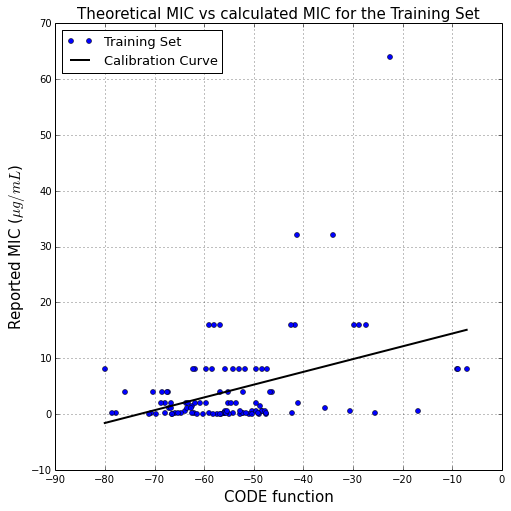



With the best coeficients an r^2 of 0.0532293968458 is obtained between the calculated and the reported MIC for the Test Set

The equation of this line is: y = 0.877583763385x + 0.869350363673


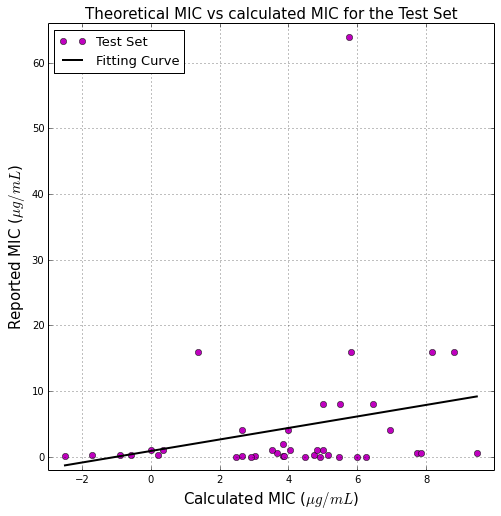




Con los mejores parametros se obtiene una pendiente ponderada en la curva de enriquecimiento de: 1.08745817469

Con los mejores parametros se obtiene un valor r-CODE de: 0.607476635514

Recuerde que r-CODE puede tomar valores entre 1.0 (Ideal) y 0.558620689655 (Aleatorio) 


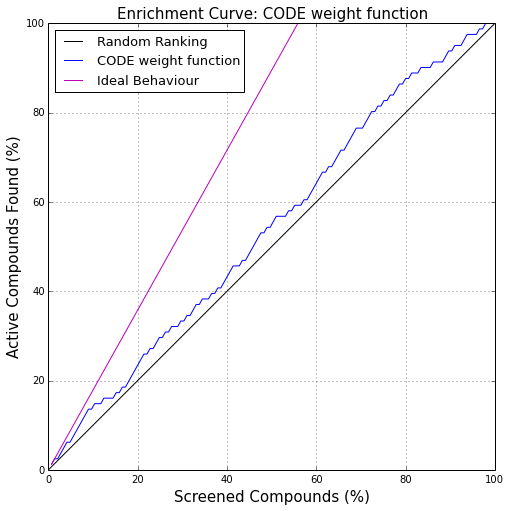

--- 23476.584888 segundos ---
Toda la informacion de este calculo se salvo en la carpeta: IteracTemp


In [22]:
iterac=81920
for i in range(0, 1):
    aviso=int(iterac/10)

    start_mom=time.strftime("%c")
    start_time = time.time()  

    coef=minimizacion(iterac); descrp=1
    if (calibracion(coef)[0]<0):
        coef[:]=coef[:]*-1
        ndxchg=1

    def datrepcal(array):
        reporcalcu=stats.linregress(array[:, coluMICcal], array[:, coluMIC])
        return reporcalcu

    datcali=calibracion(coef)
    Traincali=CODEfunc(TrainSet, coef)
    rescali(Nombre)
    testfinal=MICcal(TestSet, coef)
    datrepcal=datrepcal(testfinal)
    restest(Nombre)
    resenrique(coef, Nombre)

#coef2=minimizacion2(1); descrp=2
#resenrique(coef)

    finish_mom=time.strftime("%c")
    finish_time=time.time()

    print("--- %s segundos ---" % abs((finish_time - start_time)))
    escresultados(coef, Nombre)

    resulTemp=[[iterac, finish_time - start_time]]#[[count, numParam, iterac, finish_time - start_time, datcali[2]**2, datrepcal[2]**2, datrepcal[0], -1*pendfunc(CODEfunc(DatosArreg, coef), len(DatosArreg[0,:])-1), rCODE(DatosArreg, coef)]]

    ResultsDatabase=append(ResultsDatabase, resulTemp, axis=0)

    savetxt('IteracTemp.csv', ResultsDatabase, delimiter=',', newline='\n')
    ndxchg=0
    iterac=iterac*2